### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

#### Train the network

In [2]:
n = 10
popsize = 10
generations = 500
name = 'centered4'
#device = torch.device('mps:0')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device, popsize)

2023-02-09 12:29:33,971	INFO worker.py:1528 -- Started a local Ray instance.


[2023-02-09 12:29:36] INFO     <63351> evotorch.core: Instance of `Custom_NEProblem` (id:4369030384) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-09 12:29:36] INFO     <63351> evotorch.core: Instance of `Custom_NEProblem` (id:4369030384) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-09 12:29:36] INFO     <63351> evotorch.core: Instance of `Custom_NEProblem` (id:4369030384) -- The `device` of the problem is set as cpu
[2023-02-09 12:29:36] INFO     <63351> evotorch.core: Instance of `Custom_NEProblem` (id:4369030384) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-09 12:29:36] INFO     <63351> evotorch.core: Instance of `Custom_NEProblem` (id:4369030384) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [3]:
trainer.train(generations, name)

         iter : 1
     stepsize : ReadOnlyTensor(0.0968)
    mean_eval : -4732.81005859375
  median_eval : -4745.45166015625
pop_best_eval : -4668.4404296875
    best_eval : -4668.4404296875
   worst_eval : -4769.7099609375

         iter : 2
     stepsize : ReadOnlyTensor(0.0941)
    mean_eval : -3326.805908203125
  median_eval : -3330.55419921875
pop_best_eval : -3283.6630859375
    best_eval : -3283.6630859375
   worst_eval : -4769.7099609375

         iter : 3
     stepsize : ReadOnlyTensor(0.0922)
    mean_eval : -5341.0615234375
  median_eval : -5419.048828125
pop_best_eval : -4573.07421875
    best_eval : -3283.6630859375
   worst_eval : -5484.73046875

         iter : 4
     stepsize : ReadOnlyTensor(0.0906)
    mean_eval : -7314.63671875
  median_eval : -7327.30908203125
pop_best_eval : -7220.9970703125
    best_eval : -3283.6630859375
   worst_eval : -7410.193359375

         iter : 5
     stepsize : ReadOnlyTensor(0.0895)
    mean_eval : -3872.76708984375
  median_eval : -40

In [ ]:
network = trainer.get_trained_network()

In [ ]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'])

#### Visualize trained network

In [ ]:
organism = generate_organism(n, device)
graph = organism.toGraph()
visualizer = Visualizer()

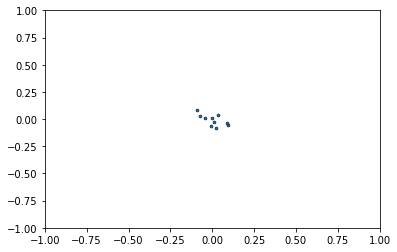

In [ ]:
anim = visualizer.animate_organism(graph, network, frames=300)
IPython.display.HTML(anim.to_jshtml())

In [ ]:
#anim.save('../animation/centered2.gif', writer='imagemagick', fps=10)
visualizer.save_animation_to_gif(anim, name, 10)

In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [ ]:
x = torch.tensor([1.0, 1.0])
y = torch.tensor([3.0, 3.0])
print(((x[0]-y[0])**2+(x[1]-y[1])**2)**0.5)
print((x-y).norm())

tensor(2.8284)
tensor(2.8284)
